In [37]:
import requests
import pandas as pd
import numpy as np

### Dataset claning and preparation
The objective in this part is to manipulate the intake and outcome datasets and have a clean database with 1 row per animal intake and the oucome of that income. 

Additionally, by taking a look on the oucome types I will decide which data should be used for the model. 

1. Merging datasets

In [38]:
# read csv file from this folder with the intakes and the outcomes
intakes = pd.read_csv('Austin_animals_intake.csv')
outcomes = pd.read_csv('Austin_animals_outcome.csv')


In [39]:
# from outcomes just selecting the important columns 'animal_id', 'datetime','outcome_type' 
outcomes = outcomes[['animal_id', 'datetime', 'outcome_type']]

In [40]:
# merging the two dataframes on 'animal_id', just using the animals that are present in both dataframes as for the rest we dont have the outcome
df = pd.merge(intakes, outcomes, on='animal_id', how='inner', suffixes=('_intake', '_outcome'))
df.head()

,animal_id,name,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type
0,A786884,*Brock,2019-01-03T16:19:00.000,2019-01-03T16:19:00.000,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor,2019-01-08T15:11:00.000,Transfer
1,A706918,Belle,2015-07-05T12:59:00.000,2015-07-05T12:59:00.000,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver,2015-07-05T15:13:00.000,Return to Owner
2,A724273,Runster,2016-04-14T18:43:00.000,2016-04-14T18:43:00.000,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White,2016-04-21T17:17:00.000,Return to Owner
3,A665644,NaN,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,2013-10-21T11:39:00.000,Transfer
4,A857105,Johnny Ringo,2022-05-12T00:23:00.000,2022-05-12T00:23:00.000,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,2 years,Domestic Shorthair,Orange Tabby,2022-05-12T14:35:00.000,Transfer


2. Do we have some animals with more than 1 intakes? if so, we need to solve this issue and assign the outcome to the specific entry. 

In [41]:
animal_id_counts = df['animal_id'].value_counts().reset_index()
animal_id_counts.columns = ['animal_id','times']
times_distribution = (
    animal_id_counts['times']
    .value_counts()
    .round(3)   # Sort by the index (number of occurrences)
).reset_index()
 
times_distribution.columns = ['times', 'frequency']
times_distribution_sorted = times_distribution.sort_values(by='times', ascending=True)
times_distribution_sorted

,times,frequency
0,1,137708
4,2,182
1,4,10351
8,6,29
2,9,1909
10,12,6
3,16,503
12,20,4
5,25,138
6,36,53


In [42]:
animal_id_counts

,animal_id,times
0,A721033,1089
1,A718223,196
2,A718877,144
3,A705625,121
4,A706536,121
...,...,...
150940,A667817,1
150941,A853959,1
150942,A902402,1
150943,A858540,1


In the table above we can see that are animals that come to the shelter more than once, some animals came 1089 times, 196, 144...  
We need to attribute the outcome to the exact intake: I would use the most close outcome by comparing timestamps.

In [43]:
# calculating the time difference between intake and outcome
df['seconds_intake_outcome'] =  pd.to_datetime(df['datetime_outcome']) - pd.to_datetime(df['datetime_intake'])
df['seconds_intake_outcome'] = df['seconds_intake_outcome'].dt.total_seconds()

# calculating the rank by using the time difference. If the time difference is negative we should not consider it
df = df[df['seconds_intake_outcome'] >= 0]
df['rank'] = df.groupby(['animal_id','datetime_intake'])['seconds_intake_outcome'].rank(ascending=True, method='first')
df =  df[df['rank'] == 1]

# getting example of the animal_id=A721033
df[df['animal_id'] == 'A721033'].sort_values(by='datetime_intake').head()

,animal_id,name,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type,seconds_intake_outcome,rank
153183,A721033,Lil Bit,2016-02-20T10:44:00.000,2016-02-20T10:44:00.000,2508 E Riverside Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,9 months,Rat Terrier Mix,Tricolor/Brown Brindle,2016-02-20T16:18:00.000,Return to Owner,20040.0,1.0
58107,A721033,Lil Bit,2016-07-10T11:53:00.000,2016-07-10T11:53:00.000,6317 E Ben White Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,1 year,Rat Terrier Mix,Tricolor/Brown Brindle,2016-07-11T17:44:00.000,Return to Owner,107460.0,1.0
180326,A721033,Lil Bit,2016-09-03T14:30:00.000,2016-09-03T14:30:00.000,6010 E Riverside in Austin (TX),Public Assist,Normal,Dog,Neutered Male,1 year,Rat Terrier Mix,Tricolor/Brown Brindle,2016-09-12T13:40:00.000,Return to Owner,774600.0,1.0
46414,A721033,Lil Bit,2016-10-20T22:47:00.000,2016-10-20T22:47:00.000,6200 E. Ben White Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,1 year,Rat Terrier Mix,Tricolor/Brown Brindle,2016-10-21T18:55:00.000,Return to Owner,72480.0,1.0
66099,A721033,Lil Bit,2016-12-15T10:07:00.000,2016-12-15T10:07:00.000,S Pleasant Valley Rd And E Riverside Dr in Aus...,Public Assist,Normal,Dog,Neutered Male,1 year,Rat Terrier Mix,Tricolor/Brown Brindle,2016-12-16T11:32:00.000,Return to Owner,91500.0,1.0


3. Is there any intake that happen between another intake and oucome?

In [44]:
# Convert datetime columns to datetime format
df['datetime_intake'] = pd.to_datetime(df['datetime_intake'])
df['datetime_outcome'] = pd.to_datetime(df['datetime_outcome'])

# Function to identify invalid rows
def mark_invalid_rows(group):
    # Create a boolean mask where a row's datetime_intake is between another row's datetime_intake and datetime_outcome
    invalid_mask = (group['datetime_intake'].apply(
        lambda dt: ((group['datetime_intake'] < dt) & (group['datetime_outcome'] > dt)).any()
    ))
    return invalid_mask

# Apply the function group-wise
df['is_invalid'] = df.groupby('animal_id', group_keys=False).apply(mark_invalid_rows)


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_23727/3290933292.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['is_invalid'] = df.groupby('animal_id', group_keys=False).apply(mark_invalid_rows)


checking if we have this cases

In [45]:
print(df.is_invalid.value_counts(normalize=False))

is_invalid
False    167240
True         42
Name: count, dtype: int64


we have few intakes incorrect but I will drop from the dataframe

In [46]:
df = df[~df['is_invalid']]

now we have our dataset with the proper format we need to start working on the model!

3. Selecting the data we need for the model. 


<Axes: xlabel='outcome_type'>

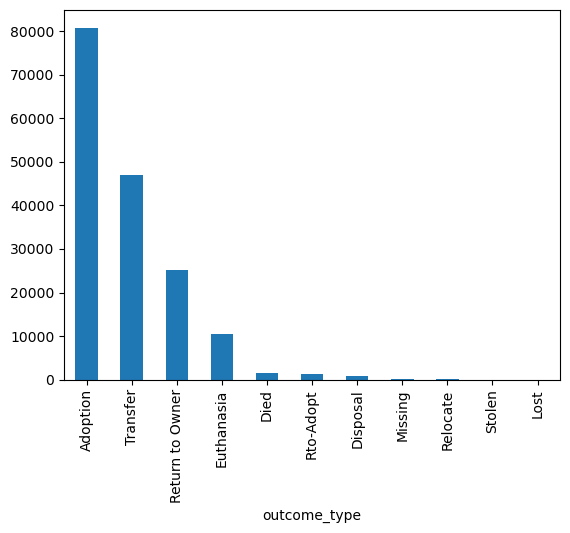

In [47]:
# animals by outcome_type in graph 
df['outcome_type'].value_counts().plot.bar() 


Explanation of Each Outcome:
* Adoption:The animal was successfully adopted by an individual or family.This is usually the desired outcome for animals in a shelter.
* Transfer:The animal was transferred to another organization, shelter, or rescue group. This can happen when the current shelter cannot accommodate the animal long-term or if another organization has better resources to care for or rehome it.
* Return to Owner:The animal was returned to its original owner.Often occurs when pets are lost and later reunited with their owners through shelter or rescue efforts.
* Euthanasia:The animal was humanely euthanized.This typically happens due to severe medical issues, behavioral problems, or lack of space in the shelter (although this is less common in no-kill shelters).
* Died:The animal passed away while in the care of the shelter or during the intake/outcome process.This could be due to natural causes, accidents, or severe health problems.
* Rto-Adopt (Return to Owner-Adopt): The animal was first returned to its original owner and then adopted by someone else. This can occur when the owner cannot continue to care for the pet and chooses to surrender it for adoption.
* Disposal: Refers to cases where the animal's remains were handled by the shelter after its passing. This may apply to animals found deceased on intake or euthanized animals.
* Missing: The animal was reported missing or lost from the shelter's care. This could be due to escape, theft, or administrative error.
* Relocate: The animal was relocated to a different geographic area, either within the organization’s network or externally. This might involve moving animals to areas with higher demand for adoptions.
* Stolen: The animal was stolen from the shelter or during transport.This is a rare occurrence but still happens occasionally.
* Lost: Similar to "Missing," this refers to animals lost during intake, care, or transport.

For simplification I will just use Addoption, Transfer, Return to owner and Euthanasia to see the time they spend in the shelter

analysing the time in the shelter by outcome_type

In [48]:
# drop duplicates
df = df.drop_duplicates()

In [49]:
# Group by outcome_type and calculate statistics 
df['unique_id'] = df['animal_id'].astype(str) + '_' + df['datetime_intake'].astype(str)
df['days_intake_outcome'] = df['seconds_intake_outcome'] / (60 * 60 * 24)

time_shelter = df.groupby('outcome_type').agg(
    total_records = ('unique_id', 'count'),  # Total rows
    mean_days=('days_intake_outcome', lambda x: round(x.mean(), 1)),  
    median_days=('days_intake_outcome', lambda x: round(x.median(), 1)),  
    percentile_95=('days_intake_outcome', lambda x: round(x.quantile(0.95), 1)),  # 95th percentile 
    percentile_05=('days_intake_outcome', lambda x: round(x.quantile(0.05), 1))  # 95th percentile 
).reset_index()


time_shelter.sort_values(by='total_records', ascending=False)


,outcome_type,total_records,mean_days,median_days,percentile_95,percentile_05
0,Adoption,80845,34.7,14.0,119.0,2.3
10,Transfer,47044,10.1,4.0,39.9,0.1
7,Return to Owner,25189,3.6,1.7,11.1,0.1
3,Euthanasia,10408,6.0,0.5,20.1,0.0
1,Died,1571,12.6,3.9,51.0,0.0
8,Rto-Adopt,1199,18.5,7.9,59.2,1.9
2,Disposal,824,6.1,1.4,23.8,0.0
5,Missing,87,51.6,38.2,133.1,3.1
6,Relocate,24,5.9,1.6,20.1,0.0
9,Stolen,5,87.7,26.4,292.4,5.7


Is interesting seeing that 50% of addoptions were produced in the first 14 days and 95% in <= 119 days.  

As it seems that transfers are very quick (50% of them 4 days or less), returns to owners are also very quick and seems that euthanasia is due to animal sickness before the intake, I would just use the Adoption outcome_type for the case.
Let´s save the data in a csv for the project.

In [50]:
df.columns


Index(['animal_id', 'name', 'datetime_intake', 'datetime2', 'found_location',
       'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
       'age_upon_intake', 'breed', 'color', 'datetime_outcome', 'outcome_type',
       'seconds_intake_outcome', 'rank', 'is_invalid', 'unique_id',
       'days_intake_outcome'],
      dtype='object')

In [51]:
df.shape    

(167240, 19)

In [52]:

df['days_intake_outcome'].describe() 

count    167240.000000
mean         20.829908
std          47.881089
min           0.000000
25%           2.003472
50%           5.979861
75%          19.309549
max        1912.938194
Name: days_intake_outcome, dtype: float64

In [53]:
# remove the records> 99 percentile
df = df[df['days_intake_outcome'] <= df['days_intake_outcome'].quantile(0.99)]

df['days_intake_outcome'].describe()

count    165567.000000
mean         17.383567
std          28.494736
min           0.000000
25%           1.979861
50%           5.913194
75%          18.259375
max         211.939583
Name: days_intake_outcome, dtype: float64

In [54]:
df.shape   

(165567, 19)

In [55]:
# create df addoptions with the outcome_type = Adoption 
df_adoptions = df[(df['outcome_type'] == 'Adoption' )& (df['animal_type'].isin(['Dog','Cat']))]

# reverse the datetime_intake to object type
df_adoptions['datetime_intake'] = df_adoptions['datetime_intake'].astype(str)
df_adoptions['datetime_outcome'] = df_adoptions['datetime_outcome'].astype(str)

#select columns that are useful for the analysis
df_adoptions = df_adoptions[['animal_id', 'name', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake', 'age_upon_intake',
       'breed', 'color', 'datetime_outcome', 'outcome_type']]


/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_23727/1854024800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adoptions['datetime_intake'] = df_adoptions['datetime_intake'].astype(str)
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_23727/1854024800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adoptions['datetime_outcome'] = df_adoptions['datetime_outcome'].astype(str)


In [56]:
df_adoptions.to_csv('data.csv', index=False)